Changing PWD to access files

In [0]:
import os
os.chdir("Documents\\Fall 2019\\ISYE 4133\\Project")

## Reading in Data and Setting up the Notebook

In [0]:
import pandas as pd
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
file = "A-n32-k5.vrp"

def read_vrp(file, branchLimit = None):
    with open("data_vrp/"+file, "r") as fin:
        #print(fin.read())
        meta_data = []
        node_coords = []
        node_demand = []
        lines = [line.strip() for line in fin.readlines()]
    node_ind = lines.index("NODE_COORD_SECTION")
    dem_ind = lines.index("DEMAND_SECTION")
    dep_ind = lines.index("DEPOT_SECTION")
    EOF = lines.index("EOF")-1
    metadata = {item.split(" : ")[0] : item.split(" : ")[1] for item in lines[:node_ind]}
    node_df = pd.DataFrame([line.split() for line in lines[node_ind+1:dem_ind]],columns = ["Node","X","Y"],dtype = np.int64)
    node_df["X"] = pd.to_numeric(node_df["X"])
    node_df["Y"] = pd.to_numeric(node_df["Y"])
    node_df["Node"] = pd.to_numeric(node_df["Node"])
    #demand_df = pd.DataFrame([line.split() for line in lines[dem_ind+1:dep_ind]],columns = ["Node","Demand"], dtype = np.int64)
    demand_dic = {int(line.split()[0]):int(line.split()[1]) for line in lines[dem_ind+1:dep_ind]}
    depots = [int(node) for node in lines[dep_ind+1:EOF]]
    if branchLimit == None:
      return metadata,node_df,demand_dic,depots
    else:
      node_subset = node_df[node_df["Node"] <= (branchLimit + len(depots))]
      demand_subset = {k:v for (k,v) in demand_dic.items() if k <= (branchLimit + len(depots))}
      return metadata,node_subset,demand_subset,depots

def euclidian_dist(df):
    return np.round(np.sqrt((pd.to_numeric(df["X"])-pd.to_numeric(df["X.1"]))*(pd.to_numeric(df["X"])-pd.to_numeric(df["X.1"])) + (pd.to_numeric(df["Y"])-pd.to_numeric(df["Y.1"]))*(pd.to_numeric(df["Y"])-pd.to_numeric(df["Y.1"]))))

def showFacilities(nodes,demand_dic):
  plt.scatter(nodes[nodes["Node"].isin(branches)]["X"],nodes[nodes["Node"].isin(branches)]["Y"],c="b")
  for i in branches:
    plt.annotate('$q_{%d}=%d$'%(i,demand_dic[i]),(nodes[nodes["Node"]==i]["X"]+2,nodes[nodes["Node"] ==i]["Y"]))
  plt.plot(nodes[nodes["Node"].isin(depots)]["X"],nodes[nodes["Node"].isin(depots)]["Y"],c="r",marker="s")
  plt.show()

def showRoutes(nodes,route_dic=None,active_arcs=None,file=None):
  plt.scatter(nodes[nodes["Node"].isin(branches)]["X"],nodes[nodes["Node"].isin(branches)]["Y"],c="b")
  # for i in branches:
  #   plt.annotate('$q_{%d}=%d$'%(i,demand_dic[i]),(nodes[nodes["Node"]==i]["X"]+2,nodes[nodes["Node"] ==i]["Y"]))
  colors = ["g","b","r","y","c","k","m"]
  if route_dic != None:
    col=0
    for route in route_dic:
      active_arcs = route
      for i,j in active_arcs:
        plt.plot([int(nodes[nodes["Node"]==i]["X"]),int(nodes[nodes["Node"]==j]["X"])],[int(nodes[nodes["Node"]==i]["Y"]),int(nodes[nodes["Node"]==j]["Y"])],c=colors[col%7],alpha=0.3)
      col+=1
  else:
    for i,j in active_arcs:
        plt.plot([int(nodes[nodes["Node"]==i]["X"]),int(nodes[nodes["Node"]==j]["X"])],[int(nodes[nodes["Node"]==i]["Y"]),int(nodes[nodes["Node"]==j]["Y"])],c="g",alpha=0.3)
  plt.plot(nodes[nodes["Node"].isin(depots)]["X"],nodes[nodes["Node"].isin(depots)]["Y"],c="r",marker="s")
  plt.savefig(file)
  plt.show()

# def showRoutes(df,route_dic=None,active_arcs = None,file=None):
#   plt.scatter(df[df["Node"]>0]["X"],df[df["Node"]>0]["Y"],c="b")
#   # for i in df[df["Node"]>0]["Node"]:
#   #   plt.annotate('$q_%d=%d$'%(i,df[df["Node"]==i]["Demand"]),(df[df["Node"]== i]["X"]+2,df[df["Node"] == i]["Y"]))
#   colors = ["g","b","r","y","c","k","m"]
#   if route_dic != None:
#     col=0
#     for route in route_dic:
#       active_arcs = route
#       for i,j in active_arcs:
#         plt.plot([int(df[df["Node"]==i]["X"]),int(df[df["Node"]==j]["X"])],[int(df[df["Node"]==i]["Y"]),int(df[df["Node"]==j]["Y"])],c=colors[col%7],alpha=0.3)
#       col+=1
#   else:
#     for i,j in active_arcs:
#         plt.plot([int(df[df["Node"]==i]["X"]),int(df[df["Node"]==j]["X"])],[int(df[df["Node"]==i]["Y"]),int(df[df["Node"]==j]["Y"])],c="g",alpha=0.3)
#   plt.plot(df[df["Node"]==0]["X"],df[df["Node"]==0]["Y"],c="r",marker="s")


meta,nodes,demand_dic,depots = read_vrp(file, branchLimit = 10)
nodes_1 = nodes.copy(deep=True)
nodes_1.columns = ["Node.1","X.1","Y.1"]
distance_df = pd.DataFrame([(i,j) for i in nodes.Node for j in nodes.Node if i != j], columns = ["Node","Node.1"])
distance_df = distance_df.merge(nodes_1,on="Node.1")
distance_df = distance_df.merge(nodes,on="Node")
distance_df.sort_values(axis =0, by=["Node","Node.1"],inplace=True)
distance_df["Distance"] = euclidian_dist(distance_df)

arcs, distance = multidict({(item[0],item[1]) : [item[2]] for item in zip(distance_df["Node"],distance_df["Node.1"],distance_df["Distance"])})
branches = [node for node in nodes.Node if node not in depots] 

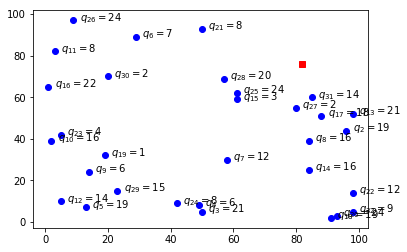

In [3]:
showFacilities(nodes,demand_dic)

## Flow Based Formulation

In [0]:
m = Model()
m.params.outputFlag = 0
flow = m.addVars(arcs,vtype=GRB.BINARY, name = "flow")
q = m.addVars(nodes.Node,vtype=GRB.CONTINUOUS,ub=int(meta["CAPACITY"]),name="q")
obj = flow.prod(distance)

m.addConstrs(flow.sum(i,"*") == 1 for i in branches)
m.addConstrs(flow.sum("*",j) == 1 for j in branches)
m.addConstrs(flow.sum(d,"*") == flow.sum("*",d) for d in depots) 
m.addConstrs(q[i] + demand_dic[j] - q[j] <= (1-flow[i,j])*int(meta["CAPACITY"]) for (i,j) in arcs if i>1 and j>1) 

# for arc in arcs:
#     if arc[0] not in depots and arc[1] not in depots:
#         m.addGenConstrIndicator(flow[arc],True,q[arc[0]] + demand_dic[arc[1]] == q[arc[1]])
#m.addConstrs(q[i]>=demand_dic[i] for i in nodes.Node if i not in depots)
m.setObjective(obj,GRB.MINIMIZE)
m.optimize()
active_arcs = [(item) for item,val in flow.items() if val.X != 0]
m.printAttr("X")

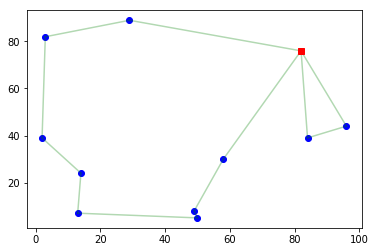

In [108]:
showRoutes(nodes,active_arcs=active_arcs, file="CVRP 10 Flow Formulation.png")

In [0]:
m.objVal

362.0

# Column Generation Formulation

Feasible Subset Creation

In [0]:
subset_dict = tupledict({arc:[] for arc in arcs})
route_cost = tupledict({})
for node in branches:
    to_include = arcs.select(1,node) + arcs.select(node,1)
    route_cost[node-2] = (np.sum(distance[arc] for arc in to_include))
    for arc in arcs:
        subset_dict[arc].append(1) if arc in to_include else subset_dict[arc].append(0)

Master Problem and Pricing Problem

In [110]:
ind = True
count = 1
while ind:
  m = Model("Column Generation VRP")
  m.params.outputFlag = 0
  X = m.addVars(len(route_cost),vtype=GRB.CONTINUOUS,name="X")
  m.addConstrs(quicksum(np.dot(subset_dict.select("*",node),X.values())) == 1 for node in branches) #flow into each branch is one over all patterns... means we visit each branch once
  obj = X.prod(route_cost) 
  m.setObjective(obj,GRB.MINIMIZE)
  m.optimize()
  m.printAttr("X")
  m.write("model"+str(count)+".lp")
  

  
  y = [con.getAttr("Pi") for con in m.getConstrs()]
  #print(y)
  reduced_branch_cost = {a:b for (a,b) in zip(branches,y)}
  reduced_branch_cost[1] = 0 ## We don't end up with a Pi for the first branch.... so i made up that it should be 0
  reduced_cost = tupledict({(i,j): distance[i,j] - reduced_branch_cost[j] for (i,j) in arcs}) 

  n = Model("Pricing Problem")
  n.params.outputFlag = 0
  n.params.TimeLimit = 20
  n.params.PoolSearchMode = 0
  n.params.PoolSolutions = 20
  n.params.Heuristics = .5

  flow = n.addVars(arcs,vtype=GRB.BINARY,name="flow")
  q = n.addVars(nodes.Node,vtype=GRB.CONTINUOUS,ub=int(meta["CAPACITY"]),name="q")
  obj = flow.prod(reduced_cost)
  
  n.addConstr(flow.sum(1,"*") == 1)
  n.addConstr(-1*flow.sum("*",1) == -1)
  n.addConstrs(flow.sum(i,"*") == flow.sum("*",i) for i in branches)
  n.addConstrs(int(meta["CAPACITY"])*(1-flow[i,j]) >= q[i] + demand_dic[j] - q[j] for (i,j) in arcs if j>1) 
  n.setObjective(obj,GRB.MINIMIZE)
  n.optimize()

  print([(item,val.X) for item,val in flow.items() if val.X !=0], max(route_cost.keys())+1,n.ObjVal, m.ObjVal)
  count += 1
  
  #adding the found solutions back into the feasible set
  if (n.objVal >= 0 or count>50):
    ind = False 
  else:
    for x in range(n.solCount):
      n.params.SolutionNumber = x
      all_vars = n.Xn
      flows = all_vars[:len(arcs)]
      zipped = tupledict({arc:flow for (arc,flow) in zip(arcs,flows)})
      if zipped.prod(reduced_cost) <= 0:
        for (arc,val) in zipped.items():
          subset_dict[arc].append(val)
        route_cost[max(route_cost.keys()) + 1] = zipped.prod(distance)


[((1, 6), 1.0), ((3, 4), 1.0), ((4, 7), 1.0), ((5, 3), 1.0), ((6, 11), 1.0), ((7, 1), 1.0), ((9, 5), 1.0), ((10, 9), 1.0), ((11, 10), 1.0)] 10 -947.0 1368.0
[((1, 5), 1.0), ((2, 1), 1.0), ((3, 4), 1.0), ((4, 8), 1.0), ((5, 3), 1.0), ((8, 2), 1.0)] 19 -188.0 421.0
[((1, 11), 1.0), ((3, 8), 1.0), ((5, 3), 1.0), ((8, 1), 1.0), ((11, 5), 1.0)] 29 -74.0 362.0
[((1, 10), 1.0), ((3, 8), 1.0), ((5, 3), 1.0), ((8, 1), 1.0), ((10, 5), 1.0)] 34 -107.0 362.0
[((1, 2), 1.0), ((2, 8), 1.0), ((3, 5), 1.0), ((5, 11), 1.0), ((7, 3), 1.0), ((8, 7), 1.0), ((11, 1), 1.0)] 40 -68.0 362.0
[((1, 6), 1.0), ((2, 1), 1.0), ((3, 7), 1.0), ((5, 3), 1.0), ((6, 5), 1.0), ((7, 8), 1.0), ((8, 2), 1.0)] 49 -84.0 362.0
[((1, 6), 1.0), ((2, 1), 1.0), ((6, 10), 1.0), ((8, 2), 1.0), ((9, 8), 1.0), ((10, 9), 1.0)] 56 -111.0 362.0
[((1, 6), 1.0), ((2, 1), 1.0), ((5, 7), 1.0), ((6, 11), 1.0), ((7, 8), 1.0), ((8, 2), 1.0), ((9, 5), 1.0), ((11, 9), 1.0)] 63 -109.0 362.0
[((1, 11), 1.0), ((2, 1), 1.0), ((3, 8), 1.0), ((8, 2), 1

In [0]:
f = Model("Column Generation VRP")
f.params.outputFlag = 0
pats = f.addVars(len(route_cost),vtype=GRB.BINARY,name="X")
f.addConstrs(quicksum(np.dot(subset_dict.select("*",node),pats.values())) == 1 for node in branches) #flow into each branch is one over all patterns... means we visit each branch once
obj = pats.prod(route_cost) 
f.setObjective(obj,GRB.MINIMIZE)
f.optimize()

In [112]:
f.ObjVal

362.0

In [0]:
def getAllPatterns(subset_dict,route_cost):
  small = pd.DataFrame.from_dict(subset_dict,orient="index")
  small = small.reset_index()
  small = small.rename(columns={"index":"Arc"})
  new_dict = {}
  for (key,val) in route_cost.items():
    try:
      new_dict[key] = val.getValue()
    except:
      new_dict[key] = val
  small = small.append(pd.Series(new_dict),ignore_index=True)
  return small
'''
Params:
pats - the X var from the final Integer program run after completion of column generation
subset_dict - the subset dictionary which was passed into master Lp at each iteration
route_cost - the cost of each pattern

Returns:
large_active_arcs: the set of all active acrs which can be passed into showRoutes
smallier - a datafram comtaining all the patterns used and their corresponding costs
'''
def getUsedPatterns(pats,subset_dict,route_cost):
  little_boy = [var for var in pats.values() if var.X > 0]
  index_list = [int(item.varName[2:-1]) for item in little_boy]
  final_pats = np.array(subset_dict.values())[:,index_list]
  patterns_taken = {arc:row for (arc,row) in zip(arcs,final_pats)}
  active_dic={arc:np.sum(row) for (arc,row) in zip(arcs,final_pats)}
  large_active_arcs = [(item) for item,val in active_dic.items() if val != 0]
  smallier = pd.DataFrame.from_dict(patterns_taken,orient="index",columns=index_list)
  smallier = smallier.reset_index()
  smallier = smallier.rename(columns={"index":"Arc"})
  smallier = smallier.append(pd.Series({index:route_cost[index] for index in index_list}),ignore_index=True)
  

  return large_active_arcs,smallier,patterns_taken
big = getAllPatterns(subset_dict,route_cost)
col_active_arcs,small,patterns_taken = getUsedPatterns(pats,subset_dict, route_cost)

patterns_taken_list = multidict(patterns_taken)[1:]
new_list = []
for item in patterns_taken_list:
   new_list.append([(key) for (key,value) in item.items() if value > 0])

In [0]:
little_boy = [var for var in pats.values() if var.X > 0]
little_boy
index_list = [int(item.varName[2:-1]) for item in little_boy]
final_pats = np.array(subset_dict.values())[:,index_list]
patterns_taken = {arc:row for (arc,row) in zip(arcs,final_pats)}
active_dic={arc:np.sum(row) for (arc,row) in zip(arcs,final_pats)}
large_active_arcs = [(item) for item,val in active_dic.items() if val != 0]
large_active_arcs

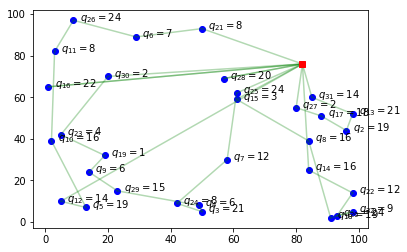

In [79]:
showRoutes(nodes,demand_dic,large_active_arcs)

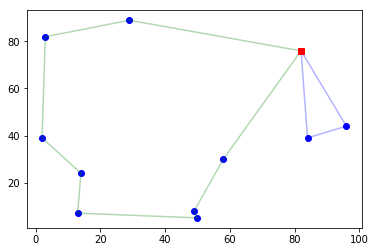

In [114]:
showRoutes(nodes,route_dic=new_list,file="CVRP 10 Column Gen Node Patterns.png")

In [0]:
patterns_taken
smallier = pd.DataFrame.from_dict(patterns_taken,orient="index",columns=index_list)
smallier = smallier.append(pd.Series({index:route_cost[index] for index in index_list}),ignore_index=True)
smallier = smallier.reset_index()
smallier.to_csv("VRP Column Generation Chosen Patterns.csv")